## This notebook explores the datasets containing Service BC service centre locations, service volumes, and transaction durations.

In [584]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
import inflection
import missingno as msno
import folium
from wordcloud import WordCloud

### Office info dataset cleaning and preprocessing

In [585]:
office_info = pd.read_csv('./data/Office info dataset.csv')

In [586]:
office_info.head()

,OfficeID,OfficeName,City,OfficeSize,Area,AreaName,Address,Latitude,Longitude
0,1,100 Mile House,100 Mile House,MICRO,4.0,Central Peace,300 Hwy 97,51.644455,-121.297478
1,2,Ashcroft,Ashcroft,MICRO,4.0,Interior,318 Railway Ave,50.720196,-121.280960
2,3,Atlin,Atlin,MICRO,1.0,Lower Mainland Capital,100 - 3rd St,59.578030,-133.689529
3,4,Bella Coola,Bella Coola,MICRO,3.0,Lower Mainland Capital,636 Cliff St,52.372311,-126.754929
4,5,Burns Lake,Burns Lake,MICRO,2.0,North Coast,161 Hwy 16,54.225189,-125.755997


* Let's clean the column names

In [587]:
office_info = office_info.rename(columns=lambda x:inflection.underscore(x))
office_info.columns

Index(['office_id', 'office_name', 'city', 'office_size', 'area', 'area_name',
       'address', 'latitude', 'longitude'],
      dtype='object')

In [588]:
office_info.isnull().sum()

office_id       0
office_name     0
city            9
office_size    10
area           10
area_name       1
address        10
latitude       10
longitude      10
dtype: int64

* There seems to be some null values in the dataset. Let's see if they are imputable or bad data.
___________________________________________________

In [589]:
null_data = office_info[office_info.isnull().any(axis=1)]
null_data

,office_id,office_name,city,office_size,area,area_name,address,latitude,longitude
62,94,Test Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,95,Send Video1,NaN,NaN,NaN,Send Video\r\n,NaN,NaN,NaN
67,99,Head Office,Head Office,NaN,NaN,Head Office,NaN,NaN,NaN
68,454,Send Video2,NaN,NaN,NaN,Send Video\r\n,NaN,NaN,NaN
69,455,Send Video3,NaN,NaN,NaN,Send Video\r\n,NaN,NaN,NaN
70,456,Send Video4,NaN,NaN,NaN,Send Video\r\n,NaN,NaN,NaN
71,457,Send Video5,NaN,NaN,NaN,Send Video\r\n,NaN,NaN,NaN
72,458,Send Video6,NaN,NaN,NaN,Send Video\r\n,NaN,NaN,NaN
73,459,Rapid Response,NaN,NaN,NaN,Rapid Response,NaN,NaN,NaN
74,500,Mobile Outreach,NaN,NaN,NaN,Mobile Outreach,NaN,NaN,NaN


* All the rows with null values in them seem unlrelated to the rest of the data and can be safely dropped.

In [590]:
print("Rows in the office dataset before cleaning: {}".format(office_info.shape[0]))
clean_office = office_info.dropna()
print("Rows in the office dataset after cleaning: {}".format(clean_office.shape[0]))

Rows in the office dataset before cleaning: 75
Rows in the office dataset after cleaning: 65


* A high level observation shows office_name and city have same data, let's check over the whole dataset if this is true. In that case, we can drop one of the columns because it is redudant information.

In [591]:
clean_office[clean_office['office_name']!=clean_office['city']]

,office_id,office_name,city,office_size,area,area_name,address,latitude,longitude
19,20,Ganges,Salt Spring Island,MICRO,3.0,Lower Mainland Capital,343 Lower Ganges Rd,48.860123,-123.508842
45,46,Daajing Giids,Queen Charlotte City,SMALL,1.0,North Coast,216 Oceanview Dr,53.254551,-132.082489


* Suprisingly there are two offices that have a different name than the city name !. So, we cannot drop either columns. At this point office dataset looks clean for further analysis.

In [592]:
# office_report = ProfileReport(clean_office, title='Office info dataset profiling')

In [593]:
# office_report.to_file("./output/office_info_report.html")

### Q visits dataset cleaning and preprocessing

In [594]:
visit_df = pd.read_csv('./data/Q visits dataset.csv')
visit_df.head()

,back_office,channel,client_id,counter_type,date,inaccurate_time,no_wait_visit,office_id,office_name,program_id,...,prep_duration_per_visit,waiting_duration_per_service,waiting_duration_per_visit,hold_duration_per_service,hold_duration_per_visit,visits_count,services_count,transactions_count,DateEntered,service_creation_duration_per_vi
0,Back Office,back-office,4736921,Counter,28SEP2020:00:00:00.000,No,Yes,94,Victoria,Back Office - 002,...,NaN,NaN,NaN,NaN,NaN,1,1,1,05MAR2021:14:30:37.450,0.000073
1,Back Office,back-office,8868074,Counter,04JAN2022:00:00:00.000,No,Yes,13,Dease Lake,ID Verification - 010,...,NaN,NaN,NaN,NaN,NaN,1,1,1,05JAN2022:02:00:13.810,0.000056
2,Front Office,in-person,2149644,NaN,14MAY2019:00:00:00.000,No,No,17,Cranbrook,F&W - 004,...,0.000011,0.004057,0.004057,NaN,NaN,1,1,1,05MAR2021:14:29:41.823,0.000165
3,Front Office,in-person,9522459,Counter,12APR2022:00:00:00.000,No,Yes,112,Send Video2,Other - 044,...,NaN,NaN,NaN,NaN,NaN,1,1,1,13APR2022:04:30:17.100,0.000004
4,Back Office,back-office,4747084,Counter,29SEP2020:00:00:00.000,No,Yes,73,Queen Charlotte City,Back Office - 004,...,NaN,NaN,NaN,NaN,NaN,1,1,1,05MAR2021:14:30:37.730,0.000067


In [595]:
visit_df = visit_df.rename(columns=lambda x: inflection.underscore(x))

In [596]:
visit_df.columns

Index(['back_office', 'channel', 'client_id', 'counter_type', 'date',
       'inaccurate_time', 'no_wait_visit', 'office_id', 'office_name',
       'program_id', 'service_count', 'status', 'welcome_time', 'latest_time',
       'service_creation_duration_outlie', 'waiting_duration_outlier',
       'prep_duration_outlier', 'serve_duration_outlier',
       'hold_duration_outlier', 'serve_duration_per_service',
       'serve_duration_per_visit', 'prep_duration_per_service',
       'prep_duration_per_visit', 'waiting_duration_per_service',
       'waiting_duration_per_visit', 'hold_duration_per_service',
       'hold_duration_per_visit', 'visits_count', 'services_count',
       'transactions_count', 'date_entered',
       'service_creation_duration_per_vi'],
      dtype='object')

In [597]:
datetime_cols = ['date','welcome_time','latest_time','date_entered']
datetime_format = '%d%b%Y:%H:%M:%S.%f'
for col in datetime_cols:
    visit_df[col] = pd.to_datetime(visit_df[col],format=datetime_format)
visit_df[datetime_cols].head()

,date,welcome_time,latest_time,date_entered
0,2020-09-28,2020-09-28 09:05:40,2020-09-28 09:21:48,2021-03-05 14:30:37.450
1,2022-01-04,2022-01-04 10:29:55,2022-01-04 10:33:48,2022-01-05 02:00:13.810
2,2019-05-14,2019-05-14 11:48:49,2019-05-14 12:13:47,2021-03-05 14:29:41.823
3,2022-04-12,2022-04-12 10:35:02,2022-04-12 10:38:29,2022-04-13 04:30:17.100
4,2020-09-29,2020-09-29 10:21:11,2020-09-29 10:24:04,2021-03-05 14:30:37.730


* From the office info dataset we know the list of offices in BC. Let's see if the unique office count in Q visits dataset is less than or equal to unique office count in office info dataset

In [598]:
unique_office_cnt= clean_office['office_name'].nunique()
unique_office_cnt

65

In [599]:
office_cnt = visit_df['office_name'].nunique()
office_cnt

71

* Looks like we have more offices in Q visit dataset. There might some bad data hiding. Let's match the office names to figure out what's happening.

In [600]:
unique_offices = set(clean_office['office_name'].unique().tolist())
unique_offices_visits = set(visit_df['office_name'].unique().tolist())

anamalous_offices = list(unique_offices_visits - unique_offices)
anamalous_offices

['Send Video5',
 'Send Video4',
 'Send Video 1',
 'Send Video3',
 'Queen Charlotte City',
 'Send Video2',
 'Head Office']

* Apart from Queen Charlotte City, rest of them don't look like office names. Hence, rows containing these office names can be safely dropped. Further analysis is required to understand why Queen Charlotte City is only a part of the Q visit dataset.

In [601]:
anamalous_offices.remove('Queen Charlotte City')
anamalous_offices

['Send Video5',
 'Send Video4',
 'Send Video 1',
 'Send Video3',
 'Send Video2',
 'Head Office']

In [602]:
print('Rows before office name is cleaned: {}'.format(visit_df.shape[0]))
clean_visit_df = visit_df[~visit_df['office_name'].isin(anamalous_offices)]
print('Rows after office name is cleaned: {}'.format(clean_visit_df.shape[0]))

Rows before office name is cleaned: 15000
Rows after office name is cleaned: 12078


* From the previous data cleaning efforts done on office info dataset, we know that two of the offices had a different name than the city name and Queen Charlotte City was one of them. Let's check the city name and match the office name.

In [603]:
clean_office[clean_office['city']=='Queen Charlotte City']

,office_id,office_name,city,office_size,area,area_name,address,latitude,longitude
45,46,Daajing Giids,Queen Charlotte City,SMALL,1.0,North Coast,216 Oceanview Dr,53.254551,-132.082489


* In the Q visits dataset, city name was used instead of the office_name for the office in Queen Charlotte City. 

* Dealing with null values in various fields

In [604]:
clean_visit_df.isnull().mean()

back_office                         0.000000
channel                             0.055142
client_id                           0.000000
counter_type                        0.293592
date                                0.000000
inaccurate_time                     0.000000
no_wait_visit                       0.000000
office_id                           0.000000
office_name                         0.000000
program_id                          0.055142
service_count                       0.000000
status                              0.000000
welcome_time                        0.000000
latest_time                         0.000000
service_creation_duration_outlie    0.000000
waiting_duration_outlier            0.000000
prep_duration_outlier               0.000000
serve_duration_outlier              0.000000
hold_duration_outlier               0.000000
serve_duration_per_service          0.119722
serve_duration_per_visit            0.121792
prep_duration_per_service           0.717834
prep_durat

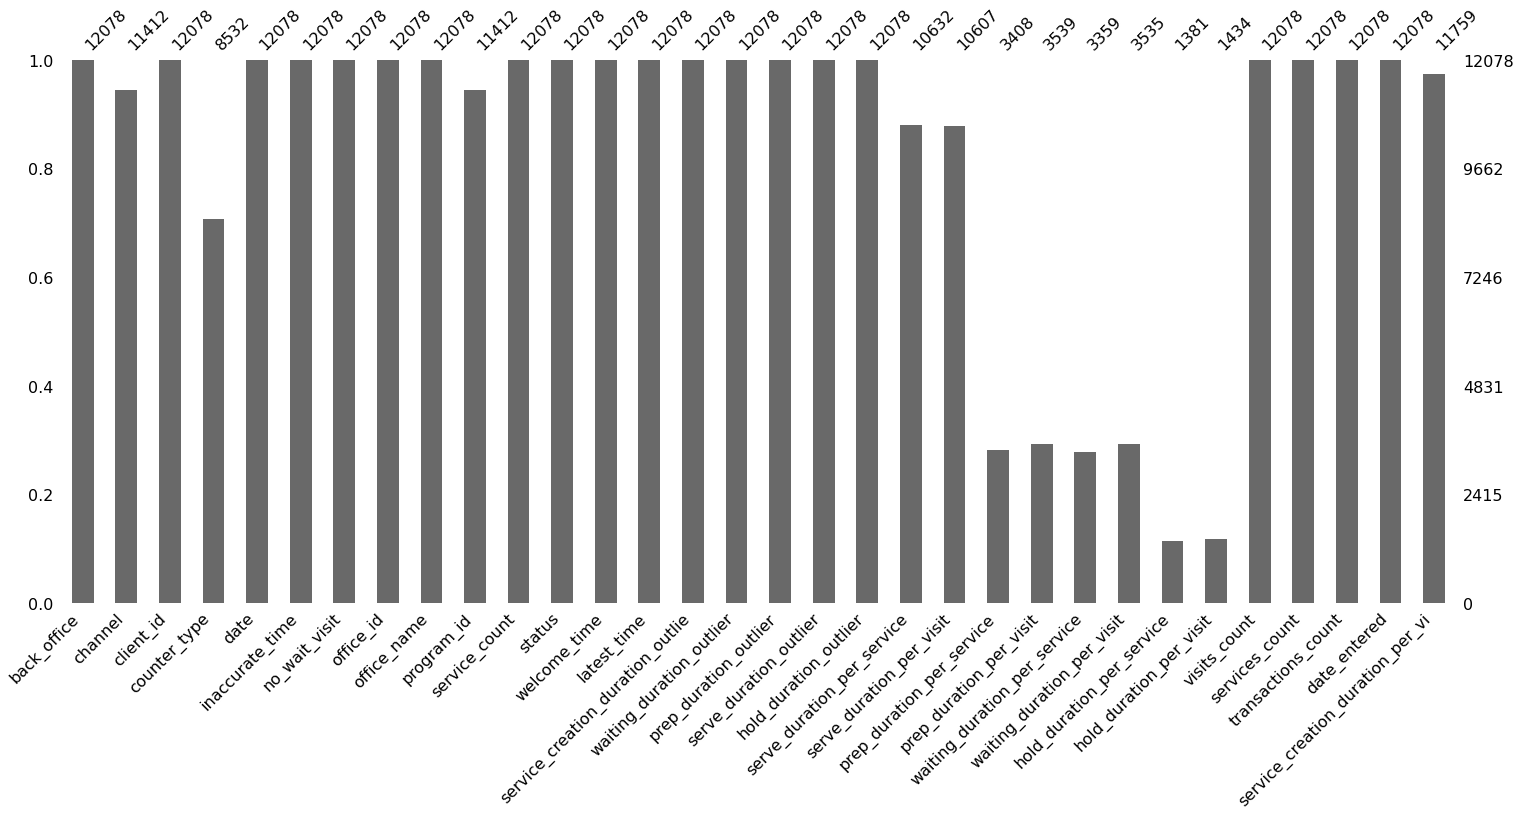

In [605]:
msno.bar(clean_visit_df)
plt.savefig('./output/Q visits non-null values by column.png');

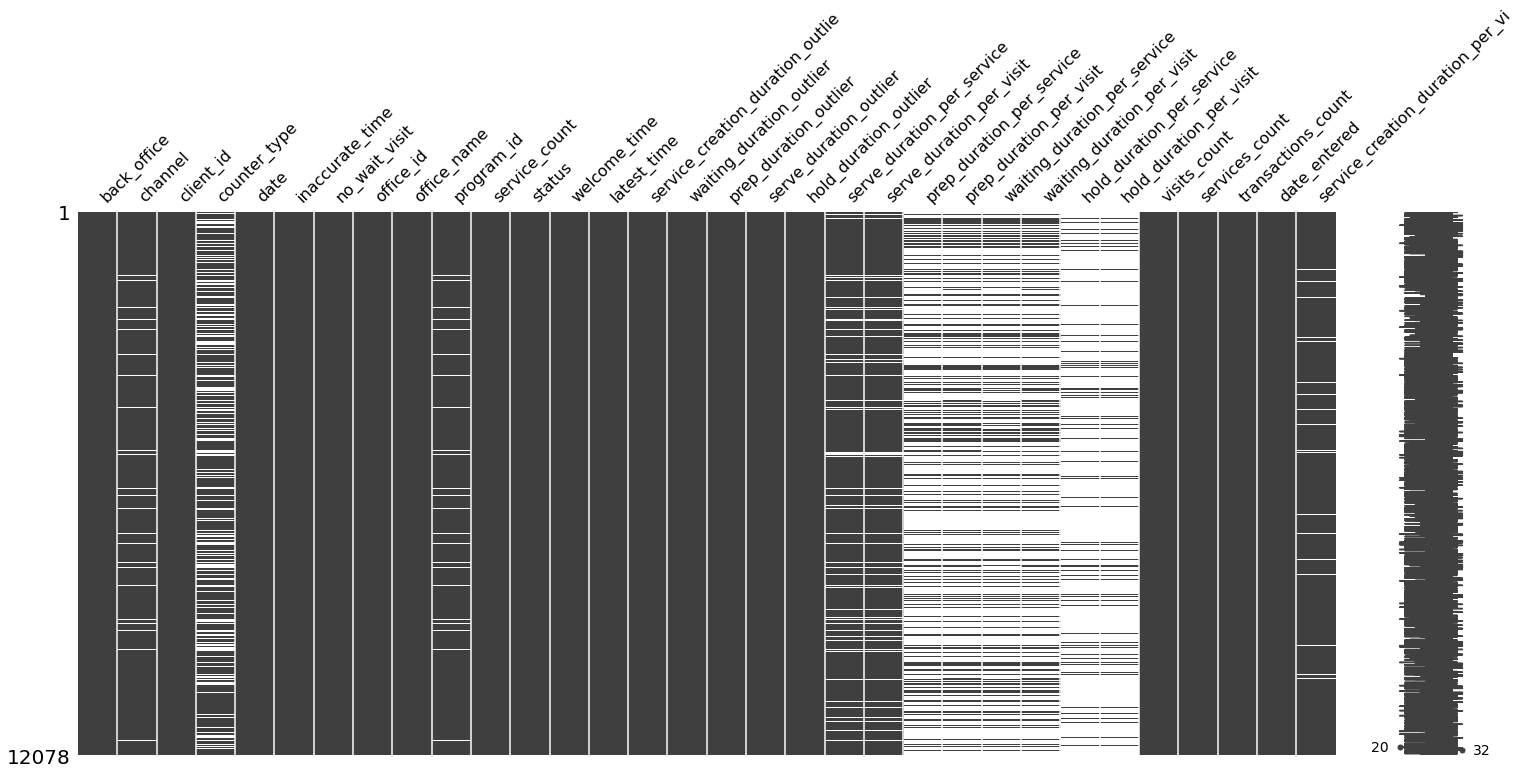

In [606]:
msno.matrix(clean_visit_df)
plt.savefig('./output/Q visits null values by row and column.png');

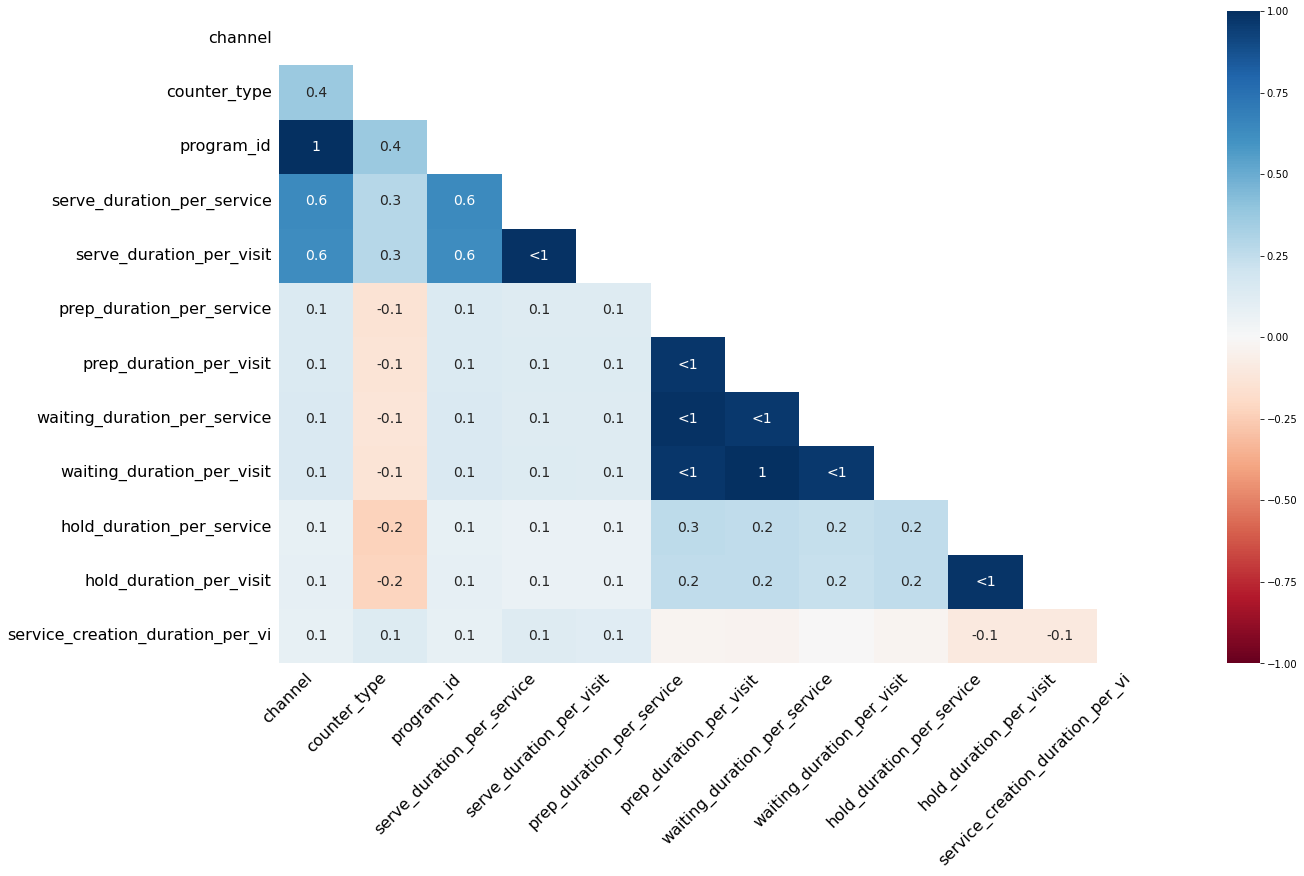

In [607]:
msno.heatmap(clean_visit_df)
plt.savefig('./output/Q visits null value correlation heatmap by position.png');

* Above statistics and the correlation heatmap show that channel and program_id are missing at the same time in all the rows. We can also see that hold duration is very sparsely populated which tells us that in the total time take for a service, hold time is generally negligible. Also, for the purposes of further analysis, we can safely impute zeroes for all the duration related fields.

* Also, there are fields denoting if the durations are outliers based on business logic. We can remove them analysis for cleaner reporting.

In [608]:
outlier_cols = [label for label in clean_visit_df.columns.tolist() if 'outlie' in label]
print('Rows before dropping outliers: {}'.format(clean_visit_df.shape[0]))
clean_visit_df = clean_visit_df[~clean_visit_df[outlier_cols].eq('Yes').any(axis=1)]
print('Rows after dropping outliers: {}'.format(clean_visit_df.shape[0]))

Rows before dropping outliers: 12078
Rows after dropping outliers: 11857


* Now that we have used the information in outlier fields, we can drop those columns as they will aid any further analysis.

In [609]:
clean_visit_df = clean_visit_df.drop(columns=outlier_cols)

### Imputation

In [610]:
duration_cols = [label for label in clean_visit_df.columns.tolist() if 'duration' in label]
print('% Null values in duration fields before imputation: {}'.format(clean_visit_df[duration_cols].isnull().mean()))
clean_visit_df.loc[:,duration_cols] = clean_visit_df.loc[:,duration_cols].fillna(0)
print('% Null values in duration fields after imputation: {}'.format(clean_visit_df[duration_cols].isnull().mean()))

% Null values in duration fields before imputation: serve_duration_per_service          0.118074
serve_duration_per_visit            0.120098
prep_duration_per_service           0.721346
prep_duration_per_visit             0.710298
waiting_duration_per_service        0.725394
waiting_duration_per_visit          0.710635
hold_duration_per_service           0.890191
hold_duration_per_visit             0.885722
service_creation_duration_per_vi    0.026398
dtype: float64
% Null values in duration fields after imputation: serve_duration_per_service          0.0
serve_duration_per_visit            0.0
prep_duration_per_service           0.0
prep_duration_per_visit             0.0
waiting_duration_per_service        0.0
waiting_duration_per_visit          0.0
hold_duration_per_service           0.0
hold_duration_per_visit             0.0
service_creation_duration_per_vi    0.0
dtype: float64


* Now that bad data and null values have been dealt with appropriately, Q visits dataset seems to be clean and ready for further analysis.

****

## EDA 
* In this section we will analyse the clean datasets, join them with each other and other publicly avaialble datasets to analyse the performance of the offices and draw insights for recommendations for improvements.

* How many offices and how many of each type does Services BC have ?

In [611]:
print('Total offices in the dataset are:{}'.format(clean_office['office_name'].nunique()))
print('Their distribution by size is as follows')
print('________________________________________')
clean_office['office_size'].value_counts()

Total offices in the dataset are:65
Their distribution by size is as follows
________________________________________


MICRO     21
SMALL     17
LARGE     15
MEDIUM    12
Name: office_size, dtype: int64

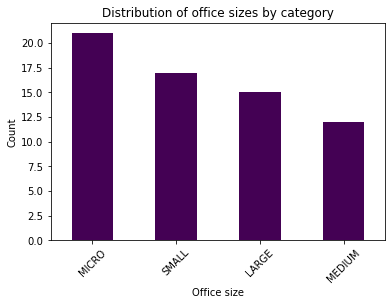

In [612]:
clean_office['office_size'].value_counts().plot(kind='bar', xlabel='Office size', ylabel='Count',
                                                 title='Distribution of office sizes by category',
                                                 colormap='viridis',
                                                 rot=45)
plt.savefig('./output/office distribution by size.png');

* How many offices are there per area name and what kind ?

In [613]:
clean_office['area_name'].value_counts()

North Coast               13
Kootenay                  13
Interior                  11
Lower Mainland Capital    11
Central Peace              9
Vancouver Island           8
Name: area_name, dtype: int64

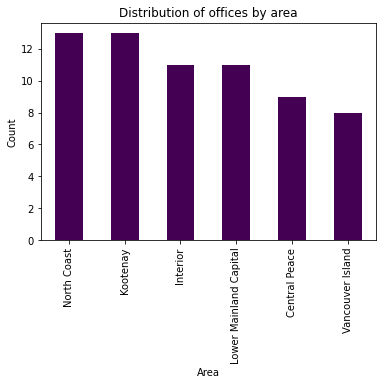

In [614]:
clean_office['area_name'].value_counts().plot(kind='bar', xlabel='Area', ylabel='Count',
                                                 title='Distribution of offices by area',
                                                 colormap='viridis')
plt.savefig('./output/office distribution by area.png');

In [615]:
clean_office.groupby('area_name')['office_size'].value_counts()

area_name               office_size
Central Peace           LARGE          3
                        MEDIUM         2
                        MICRO          2
                        SMALL          2
Interior                MICRO          5
                        LARGE          3
                        MEDIUM         2
                        SMALL          1
Kootenay                SMALL          7
                        MICRO          3
                        LARGE          2
                        MEDIUM         1
Lower Mainland Capital  LARGE          3
                        MEDIUM         3
                        MICRO          3
                        SMALL          2
North Coast             MICRO          7
                        MEDIUM         3
                        SMALL          3
Vancouver Island        LARGE          4
                        SMALL          2
                        MEDIUM         1
                        MICRO          1
Name: office_size, dt

* Although north coast has the highest number of offices, more than half of them are micro sized.

* Central Peace = Cariboo + North east
* North coast = North coast + Nechako
* Interior = Thompson/Okanagon


* Let's see where the offices are located and if there is bad data in locations (office outside British Columbia).

In [616]:
geometry = [Point(xy) for xy in zip(clean_office.longitude, clean_office.latitude)]
office_gdf = gpd.GeoDataFrame(clean_office, crs="EPSG:4326", geometry=geometry)

In [617]:
office_gdf.head()

,office_id,office_name,city,office_size,area,area_name,address,latitude,longitude,geometry
0,1,100 Mile House,100 Mile House,MICRO,4.0,Central Peace,300 Hwy 97,51.644455,-121.297478,POINT (-121.29748 51.64446)
1,2,Ashcroft,Ashcroft,MICRO,4.0,Interior,318 Railway Ave,50.720196,-121.280960,POINT (-121.28096 50.72020)
2,3,Atlin,Atlin,MICRO,1.0,Lower Mainland Capital,100 - 3rd St,59.578030,-133.689529,POINT (-133.68953 59.57803)
3,4,Bella Coola,Bella Coola,MICRO,3.0,Lower Mainland Capital,636 Cliff St,52.372311,-126.754929,POINT (-126.75493 52.37231)
4,5,Burns Lake,Burns Lake,MICRO,2.0,North Coast,161 Hwy 16,54.225189,-125.755997,POINT (-125.75600 54.22519)


In [618]:
# Path to the shapefile
shapefile_path = './data/location_data/lpr_000b21a_e.shp'

# Read the shapefile into a GeoDataFrame
provinces_gdf = gpd.read_file(shapefile_path)

bc_boundary = provinces_gdf[provinces_gdf['PRENAME'] == 'British Columbia']
bc_boundary

,PRUID,DGUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,LANDAREA,geometry
9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544,"MULTIPOLYGON (((3843551.097 2389750.100, 38435..."


In [619]:
# # Create a folium map centered around British Columbia
# bc_map = folium.Map(location=[53.7267, -127.6476], zoom_start=6)

# # Add the BC boundary to the map
# folium.GeoJson(bc_boundary).add_to(bc_map)

# # Iterate over the office locations GeoDataFrame
# for idx, row in office_gdf.iterrows():
#     # Extract the latitude and longitude from the office location geometry
#     lon, lat = row.geometry.coords[0]
    
#     # Create a marker for each office location and add it to the map
#     marker = folium.Marker(location=[lat, lon])

#     # Create a tooltip with the city name
#     tooltip = folium.Tooltip(text=row['city'])
    
#     # Add the tooltip to the marker
#     marker.add_child(tooltip)

#     # Add the marker to the map
#     marker.add_to(bc_map)


# # Display the map
# bc_map

In [620]:
# bc_map.save('./output/office_locations.html')

* Q visits dataset can be joined with office info dataset using the foreign key (office_id) in the former with the primary key office_id in the latter.But upon analysing the two datasets, it looks like office_id is an auto_increment column in the office info dataset and not a key that can be used to join the tables.

* So, that leaves us with joining on office_name instead. Office name in Q visits can be used as a key to join office info dataset on either city or office_name.

* But, as we noticed above for one the offices in Queen Charlotte city, office name was different than city in office info dataset. So, let's create a new column that will same values as office name for all rows except for the one in Queen Charlotte city. We can then use this new column to merge both the datasets.

In [621]:
clean_office[clean_office['city']=='Queen Charlotte City']

,office_id,office_name,city,office_size,area,area_name,address,latitude,longitude
45,46,Daajing Giids,Queen Charlotte City,SMALL,1.0,North Coast,216 Oceanview Dr,53.254551,-132.082489


In [622]:
clean_office.loc[clean_office['office_name'] == 'Daajing Giids', 'merge_key'] = clean_office.loc[clean_office['office_name'] == 'Daajing Giids', 'city']
clean_office.loc[clean_office['office_name'] != 'Daajing Giids', 'merge_key'] = clean_office.loc[clean_office['office_name'] != 'Daajing Giids', 'office_name']

<ipython-input-622-f5e959c2baf6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_office.loc[clean_office['office_name'] == 'Daajing Giids', 'merge_key'] = clean_office.loc[clean_office['office_name'] == 'Daajing Giids', 'city']


In [623]:
clean_office.loc[clean_office['office_name'] == 'Daajing Giids']

,office_id,office_name,city,office_size,area,area_name,address,latitude,longitude,merge_key
45,46,Daajing Giids,Queen Charlotte City,SMALL,1.0,North Coast,216 Oceanview Dr,53.254551,-132.082489,Queen Charlotte City


In [624]:
clean_office.columns

Index(['office_id', 'office_name', 'city', 'office_size', 'area', 'area_name',
       'address', 'latitude', 'longitude', 'merge_key'],
      dtype='object')

In [625]:
cols_needed = ['office_size', 'area_name','latitude','longitude','merge_key']
merged_visit_df = clean_visit_df.merge(clean_office[cols_needed],left_on='office_name',right_on='merge_key').drop(columns='merge_key')
merged_visit_df.head()

,back_office,channel,client_id,counter_type,date,inaccurate_time,no_wait_visit,office_id,office_name,program_id,...,hold_duration_per_visit,visits_count,services_count,transactions_count,date_entered,service_creation_duration_per_vi,office_size,area_name,latitude,longitude
0,Back Office,back-office,4736921,Counter,2020-09-28,No,Yes,94,Victoria,Back Office - 002,...,0.0,1,1,1,2021-03-05 14:30:37.450,0.000073,LARGE,Lower Mainland Capital,48.458359,-123.377106
1,Back Office,back-office,5117850,Counter,2020-11-30,No,Yes,111,Victoria,ID Verification - 010,...,0.0,1,1,1,2021-03-05 14:30:50.080,0.000148,LARGE,Lower Mainland Capital,48.458359,-123.377106
2,Front Office,in-person,1131655,NaN,2019-01-31,Yes,No,94,Victoria,SDPR - POC - 009,...,0.0,1,1,1,2021-03-05 14:29:32.667,0.000349,LARGE,Lower Mainland Capital,48.458359,-123.377106
3,Back Office,back-office,4105534,Counter,2020-06-09,No,Yes,94,Victoria,Back Office - 020,...,0.0,1,1,1,2021-03-05 14:30:19.887,0.000006,LARGE,Lower Mainland Capital,48.458359,-123.377106
4,Front Office,in-person,4380879,Counter,2020-07-28,Yes,No,94,Victoria,MSP - 001,...,0.0,1,1,1,2021-03-05 14:30:27.353,0.000005,LARGE,Lower Mainland Capital,48.458359,-123.377106


In [626]:
transactions_by_office = merged_visit_df.groupby('office_name')['client_id'].count().sort_values()

In [627]:
transactions_by_office

office_name
Masset            11
Clinton           14
Bella Coola       20
Kaslo             34
Valemount         35
                ... 
Port Alberni     442
Courtenay        464
Maple Ridge      506
Prince George    552
Vernon           628
Name: client_id, Length: 65, dtype: int64

In [628]:
transactions_by_area = merged_visit_df.groupby('area_name')['client_id'].count().sort_values()
transactions_by_area

area_name
North Coast               1471
Kootenay                  1725
Vancouver Island          2113
Central Peace             2151
Interior                  2190
Lower Mainland Capital    2207
Name: client_id, dtype: int64

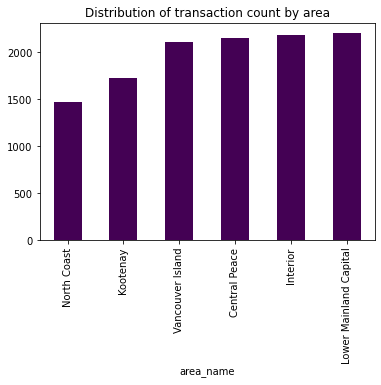

In [629]:
transactions_by_area.plot(kind='bar',colormap='viridis')
plt.title('Distribution of transaction count by area')
plt.savefig('./output/distribution of transaction count by area.png');

In [630]:
merged_visit_df['program_id'].value_counts()

ICBC - 002                1450
ID Verification - 010     1207
Back Office - 021         1119
ICBC - 008                 481
ICBC - 009                 336
                          ... 
Other - 006                  1
LCRB - 005                   1
MCFD - 001                   1
SDPR - 3rd Party - 008       1
SDPR - POC - 002             1
Name: program_id, Length: 182, dtype: int64

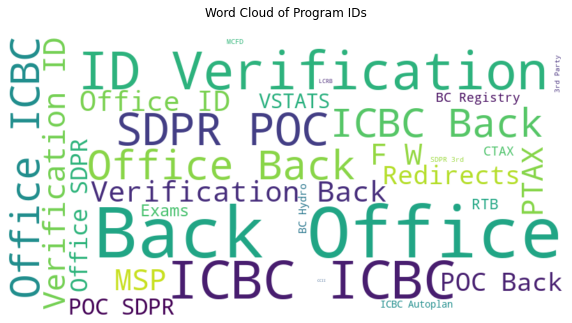

In [631]:
# Concatenate all program IDs into a single string
text = ' '.join(merged_visit_df['program_id'].dropna().astype(str))

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Program IDs', pad=20)
# plt.savefig('./output/word cloud of programs.png')
plt.show()

In [632]:
merged_visit_df.groupby(['area_name','program_id'])['client_id'].count().sort_values(ascending=False)

area_name               program_id           
Vancouver Island        ICBC - 002               379
Lower Mainland Capital  ID Verification - 010    379
Central Peace           ICBC - 002               321
Interior                ICBC - 002               274
Kootenay                Back Office - 021        246
                                                ... 
North Coast             Other - 047                1
Kootenay                BC Registry - 002          1
North Coast             RTB - 001                  1
                        RTB - 002                  1
                        Redirects - 004            1
Name: client_id, Length: 733, dtype: int64

In [633]:
# Group the DataFrame by 'area' and 'program_id', and count the occurrences
program_counts = merged_visit_df.groupby(['area_name', 'program_id']).size().reset_index(name='count')

# Sort the program_counts DataFrame within each 'area' by the count in descending order
program_counts_sorted = program_counts.groupby('area_name').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Display the top 5 programs handled by each area
print(program_counts_sorted)

                 area_name             program_id  count
0            Central Peace             ICBC - 002    321
1            Central Peace      Back Office - 021    167
2            Central Peace  ID Verification - 010    162
3            Central Peace             ICBC - 008    124
4            Central Peace             PTAX - 005     88
5                 Interior             ICBC - 002    274
6                 Interior      Back Office - 021    207
7                 Interior  ID Verification - 010    185
8                 Interior             ICBC - 009     73
9                 Interior             ICBC - 008     66
10                Kootenay      Back Office - 021    246
11                Kootenay  ID Verification - 010    154
12                Kootenay             ICBC - 002    149
13                Kootenay             PTAX - 005     76
14                Kootenay      Back Office - 004     72
15  Lower Mainland Capital  ID Verification - 010    379
16  Lower Mainland Capital     

In [634]:
merged_visit_df.groupby('office_size')['client_id'].count().sort_values()

office_size
MICRO     1489
SMALL     1568
MEDIUM    2968
LARGE     5832
Name: client_id, dtype: int64

In [635]:
clean_office.groupby(['office_size'])['office_name'].count().sort_values()

office_size
MEDIUM    12
LARGE     15
SMALL     17
MICRO     21
Name: office_name, dtype: int64

In [636]:
merged_visit_df.head()

,back_office,channel,client_id,counter_type,date,inaccurate_time,no_wait_visit,office_id,office_name,program_id,...,hold_duration_per_visit,visits_count,services_count,transactions_count,date_entered,service_creation_duration_per_vi,office_size,area_name,latitude,longitude
0,Back Office,back-office,4736921,Counter,2020-09-28,No,Yes,94,Victoria,Back Office - 002,...,0.0,1,1,1,2021-03-05 14:30:37.450,0.000073,LARGE,Lower Mainland Capital,48.458359,-123.377106
1,Back Office,back-office,5117850,Counter,2020-11-30,No,Yes,111,Victoria,ID Verification - 010,...,0.0,1,1,1,2021-03-05 14:30:50.080,0.000148,LARGE,Lower Mainland Capital,48.458359,-123.377106
2,Front Office,in-person,1131655,NaN,2019-01-31,Yes,No,94,Victoria,SDPR - POC - 009,...,0.0,1,1,1,2021-03-05 14:29:32.667,0.000349,LARGE,Lower Mainland Capital,48.458359,-123.377106
3,Back Office,back-office,4105534,Counter,2020-06-09,No,Yes,94,Victoria,Back Office - 020,...,0.0,1,1,1,2021-03-05 14:30:19.887,0.000006,LARGE,Lower Mainland Capital,48.458359,-123.377106
4,Front Office,in-person,4380879,Counter,2020-07-28,Yes,No,94,Victoria,MSP - 001,...,0.0,1,1,1,2021-03-05 14:30:27.353,0.000005,LARGE,Lower Mainland Capital,48.458359,-123.377106


In [637]:
# Group the DataFrame by 'area' and 'program_id', and count the occurrences
program_counts_by_office = merged_visit_df.groupby(['office_name', 'program_id']).size().reset_index(name='count')

# Sort the program_counts DataFrame within each 'area' by the count in descending order
program_counts_sorted_by_office = program_counts_by_office.groupby('office_name').apply(lambda x: x.nlargest(2, 'count')).reset_index(drop=True)

# Display the top 5 programs handled by each area
print(program_counts_sorted_by_office)

        office_name             program_id  count
0    100 Mile House  ID Verification - 010     30
1    100 Mile House      Back Office - 021     25
2          Ashcroft      Back Office - 021      8
3          Ashcroft  ID Verification - 010      6
4             Atlin  ID Verification - 010     10
..              ...                    ...    ...
125          Vernon      Back Office - 021     58
126        Victoria  ID Verification - 010     51
127        Victoria      Back Office - 021     49
128   Williams Lake             ICBC - 002     40
129   Williams Lake             ICBC - 008     24

[130 rows x 3 columns]


In [638]:
merged_visit_df['total_service_time'] = (merged_visit_df['latest_time']-merged_visit_df['welcome_time']).astype('timedelta64[s]')
merged_visit_df['total_service_time'].head()

0     968.0
1     112.0
2    1010.0
3     538.0
4      12.0
Name: total_service_time, dtype: float64

In [639]:
merged_visit_df[duration_cols] = merged_visit_df[duration_cols]*24*3600
merged_visit_df[duration_cols].head()

,serve_duration_per_service,serve_duration_per_visit,prep_duration_per_service,prep_duration_per_visit,waiting_duration_per_service,waiting_duration_per_visit,hold_duration_per_service,hold_duration_per_visit,service_creation_duration_per_vi
0,961.666966,961.666966,0.000000,0.000000,0.000000,0.000000,0.0,0.0,6.272001
1,99.234996,99.234996,0.000000,0.000000,0.000000,0.000000,0.0,0.0,12.749003
2,0.000000,0.000000,786.234963,786.234963,191.760998,191.760998,0.0,0.0,30.150999
3,537.508008,537.508008,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.530000
4,0.000000,0.000000,3.393999,3.393999,5.390997,5.390997,0.0,0.0,0.446000


In [640]:
merged_visit_df['cumulative_service_time_per_service'] = round(merged_visit_df['serve_duration_per_service']+merged_visit_df['prep_duration_per_service']+merged_visit_df['waiting_duration_per_service']+merged_visit_df['hold_duration_per_service']+merged_visit_df['service_creation_duration_per_vi'])

In [641]:
merged_visit_df['cumulative_service_time_per_visit'] = round(merged_visit_df['serve_duration_per_visit']+merged_visit_df['prep_duration_per_visit']+merged_visit_df['waiting_duration_per_visit']+merged_visit_df['hold_duration_per_visit']+merged_visit_df['service_creation_duration_per_vi'])

In [642]:
inaccurate_time = merged_visit_df[merged_visit_df['inaccurate_time']=='Yes']

In [643]:
merged_visit_df['service_count'].value_counts()

1     11369
2       381
3        69
4        19
5         6
6         4
7         4
8         2
19        1
13        1
17        1
Name: service_count, dtype: int64

In [644]:
merged_visit_df['inaccurate_time'].value_counts()

No     11210
Yes      647
Name: inaccurate_time, dtype: int64

In [645]:
merged_visit_df['no_wait_visit'].value_counts()

Yes    8099
No     3758
Name: no_wait_visit, dtype: int64

In [646]:
merged_visit_df[(merged_visit_df['no_wait_visit']=='Yes')&((merged_visit_df['waiting_duration_per_service']!=0) | (merged_visit_df['waiting_duration_per_visit']!=0))].sample(5).T

,2468,1942,458,5974,6545
back_office,Front Office,Front Office,Front Office,Front Office,Front Office
channel,in-person,in-person,in-person,in-person,in-person
client_id,1371628,1971025,8883181,9967266,1658090
counter_type,NaN,NaN,Counter,Counter,NaN
date,2019-02-27 00:00:00,2019-04-26 00:00:00,2022-01-05 00:00:00,2022-06-20 00:00:00,2019-03-29 00:00:00
inaccurate_time,No,No,No,No,No
no_wait_visit,Yes,Yes,Yes,Yes,Yes
office_id,93,65,17,68,66
office_name,Vernon,Penticton,Cranbrook,Prince George,Port Alberni
program_id,VSTATS - 001,RTB - 001,ICBC - 002,PTAX - 010,ICBC - 002


In [647]:
merged_visit_df[['no_wait_visit','waiting_duration_per_service','waiting_duration_per_visit']].groupby('no_wait_visit').quantile([0.25,0.97])

waiting_duration_per_service  waiting_duration_per_visit
no_wait_visit                                                               
No            0.25                      0.647000                    1.321752
              0.97                   2088.584853                 2092.199297
Yes           0.25                      0.000000                    0.000000
              0.97                      0.000000                    0.000000

In [648]:
time_cols = duration_cols + ['total_service_time','cumulative_service_time_per_service','cumulative_service_time_per_visit']
merged_visit_df[time_cols].describe()

,serve_duration_per_service,serve_duration_per_visit,prep_duration_per_service,prep_duration_per_visit,waiting_duration_per_service,waiting_duration_per_visit,hold_duration_per_service,hold_duration_per_visit,service_creation_duration_per_vi,total_service_time,cumulative_service_time_per_service,cumulative_service_time_per_visit
count,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000
mean,398.329285,440.698463,3.622552,4.059011,135.390263,144.997449,250.883981,278.705486,18.776246,1009.500042,806.998651,887.233786
std,622.515934,740.960665,28.645501,31.587808,401.557794,422.292439,2024.739063,2135.046918,50.313731,6017.206133,2254.604563,2431.442574
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.049995,50.368997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.952996,96.000000,81.000000,90.000000
50%,215.719010,234.857007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.559998,336.000000,296.000000,330.000000
75%,490.274994,530.504986,0.002000,0.966004,0.002000,3.284997,0.000000,0.000000,15.828998,867.000000,788.000000,857.000000
max,11324.040123,14677.020694,2213.951054,2213.951054,5431.081225,8347.586993,81827.770044,81827.770044,1805.884070,414991.000000,81838.000000,81838.000000


In [649]:
visit_95_data = merged_visit_df[(merged_visit_df['total_service_time']<=merged_visit_df['total_service_time'].quantile(0.95))&(merged_visit_df['total_service_time']>=merged_visit_df['total_service_time'].quantile(0.05))]

<ipython-input-650-0afb38d57536>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  visit_95_data[time_cols].hist(bins=30,ax=ax)


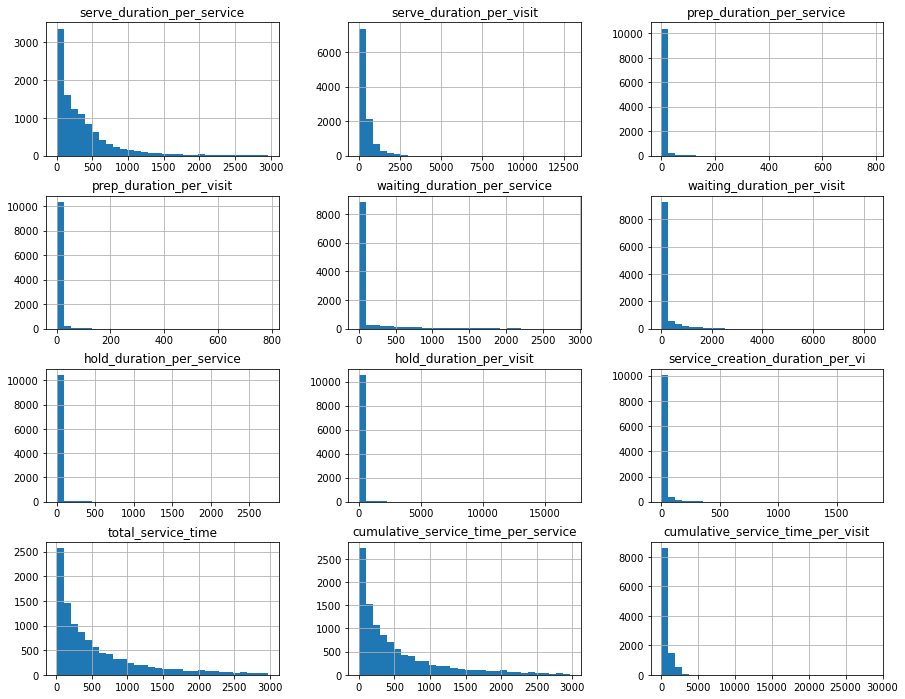

In [650]:
fig, ax = plt.subplots(figsize=(15,12))
visit_95_data[time_cols].hist(bins=30,ax=ax)
plt.savefig('Distribution of different components of service duration.png');

In [651]:
time_cols

['serve_duration_per_service',
 'serve_duration_per_visit',
 'prep_duration_per_service',
 'prep_duration_per_visit',
 'waiting_duration_per_service',
 'waiting_duration_per_visit',
 'hold_duration_per_service',
 'hold_duration_per_visit',
 'service_creation_duration_per_vi',
 'total_service_time',
 'cumulative_service_time_per_service',
 'cumulative_service_time_per_visit']

In [652]:
time_stats_by_office = merged_visit_df[time_cols +['client_id','office_name','area_name','office_size']].groupby(['office_name','area_name','office_size']).agg(transaction_count = ('client_id','count'),
                                                                                                                                    median_serve_duration_per_service = ('serve_duration_per_service','median'),
                                                                                                                        median_serve_duration_per_visit = ('serve_duration_per_visit','median'),
                                                                                                                        median_service_creation_duration_per_visit = ('service_creation_duration_per_vi','median'),
                                                                                                                        median_prep_duration_per_visit = ('prep_duration_per_visit','median'),
                                                                                                                        median_prep_duration_per_service = ('prep_duration_per_service','median'),
                                                                                                                        median_waiting_duration_per_visit = ('waiting_duration_per_visit','median'),
                                                                                                                        median_waiting_duration_per_service = ('waiting_duration_per_service','median'),
                                                                                                                        median_hold_duration_per_visit = ('hold_duration_per_visit','median'),
                                                                                                                        median_hold_duration_per_service = ('hold_duration_per_service','median'),
                                                                                                                        median_total_service_time = ('total_service_time','median'),
                                                                                                                        median_cumulative_service_time_per_service = ('cumulative_service_time_per_service','median'),
                                                                                                                        median_cumulative_service_time_per_visit = ('cumulative_service_time_per_visit','median'),
                                                                                                                        mean_serve_duration_per_service = ('serve_duration_per_service','mean'),
                                                                                                                        mean_serve_duration_per_visit = ('serve_duration_per_visit','mean'),
                                                                                                                        mean_service_creation_duration_per_visit = ('service_creation_duration_per_vi','mean'),
                                                                                                                        mean_prep_duration_per_visit = ('prep_duration_per_visit','mean'),
                                                                                                                        mean_prep_duration_per_service = ('prep_duration_per_service','mean'),
                                                                                                                        mean_waiting_duration_per_visit = ('waiting_duration_per_visit','mean'),
                                                                                                                        mean_waiting_duration_per_service = ('waiting_duration_per_service','mean'),
                                                                                                                        mean_hold_duration_per_visit = ('hold_duration_per_visit','mean'),
                                                                                                                        mean_hold_duration_per_service = ('hold_duration_per_service','mean'),
                                                                                                                        mean_total_service_time = ('total_service_time','mean'),
                                                                                                                        mean_cumulative_service_time_per_service = ('cumulative_service_time_per_service','mean'),
                                                                                                                        mean_cumulative_service_time_per_visit = ('cumulative_service_time_per_visit','mean')
                                                                                                              ).reset_index()

In [653]:
time_stats_by_office.sample(5).T

,53,37,58,13,33
office_name,Squamish,Nelson,Ucluelet,Dawson Creek,Masset
area_name,Lower Mainland Capital,Kootenay,Vancouver Island,Central Peace,North Coast
office_size,SMALL,LARGE,MICRO,MEDIUM,MICRO
transaction_count,149,324,60,265,11
median_serve_duration_per_service,132.497001,247.163003,71.039998,214.299,342.987998
median_serve_duration_per_visit,132.497001,255.193999,71.039998,219.385999,342.987998
median_service_creation_duration_per_visit,3.959004,4.469999,2.143502,7.412999,6.949999
median_prep_duration_per_visit,0.0,0.0,0.0,0.0,0.0
median_prep_duration_per_service,0.0,0.0,0.0,0.0,0.0
median_waiting_duration_per_visit,0.0,0.0,0.0,0.0,0.0


In [654]:
time_stats_by_office.sort_values(by='median_cumulative_service_time_per_visit')[['office_name','area_name','office_size','transaction_count','median_cumulative_service_time_per_visit']].head(5).T

,55,18,58,59,4
office_name,Surrey,Fort St. James,Ucluelet,Valemount,Burnaby
area_name,Lower Mainland Capital,North Coast,Vancouver Island,Interior,Lower Mainland Capital
office_size,MEDIUM,MICRO,MICRO,MICRO,MEDIUM
transaction_count,181,187,60,35,186
median_cumulative_service_time_per_visit,51.0,64.0,77.5,101.0,112.5


In [655]:
time_stats_by_office.sort_values(by='median_cumulative_service_time_per_visit')[['office_name','area_name','transaction_count','median_cumulative_service_time_per_visit']].tail(5).T

,10,39,49,43,62
office_name,Courtenay,Penticton,Salmon Arm,Prince George,Vernon
area_name,Vancouver Island,Interior,Interior,Central Peace,Interior
transaction_count,464,372,355,552,628
median_cumulative_service_time_per_visit,587.0,598.0,621.0,629.5,664.5


In [656]:
merged_visit_df['office_size'].value_counts()

LARGE     5832
MEDIUM    2968
SMALL     1568
MICRO     1489
Name: office_size, dtype: int64

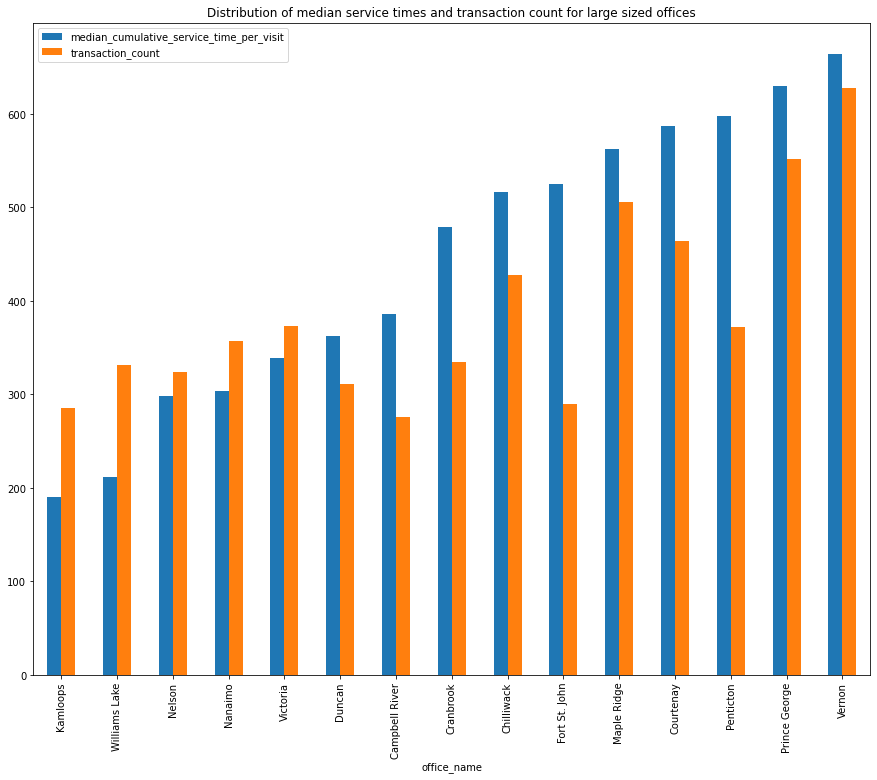

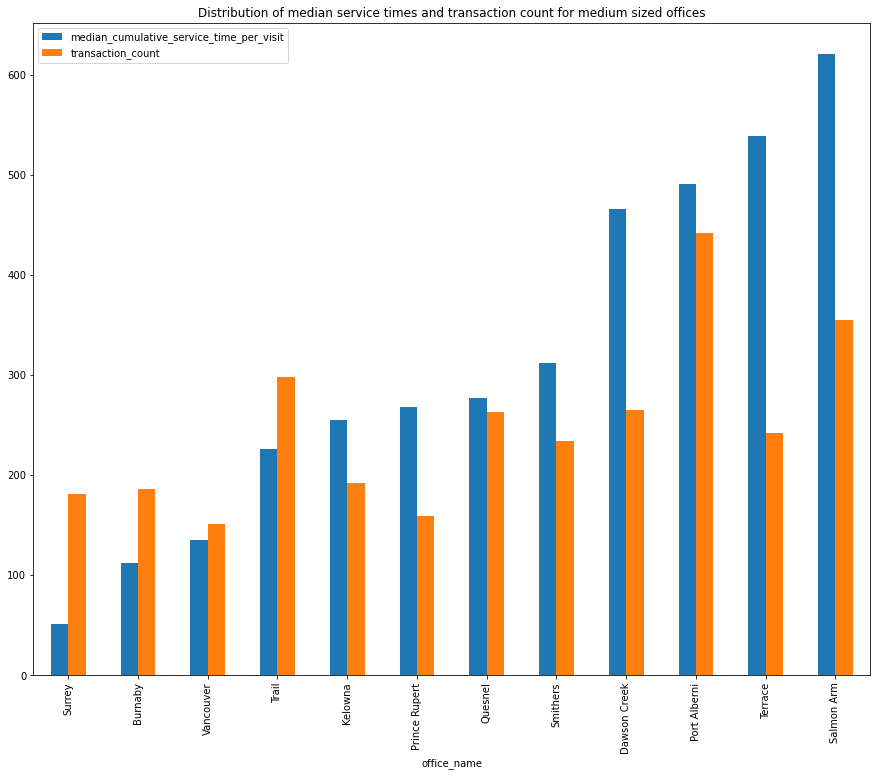

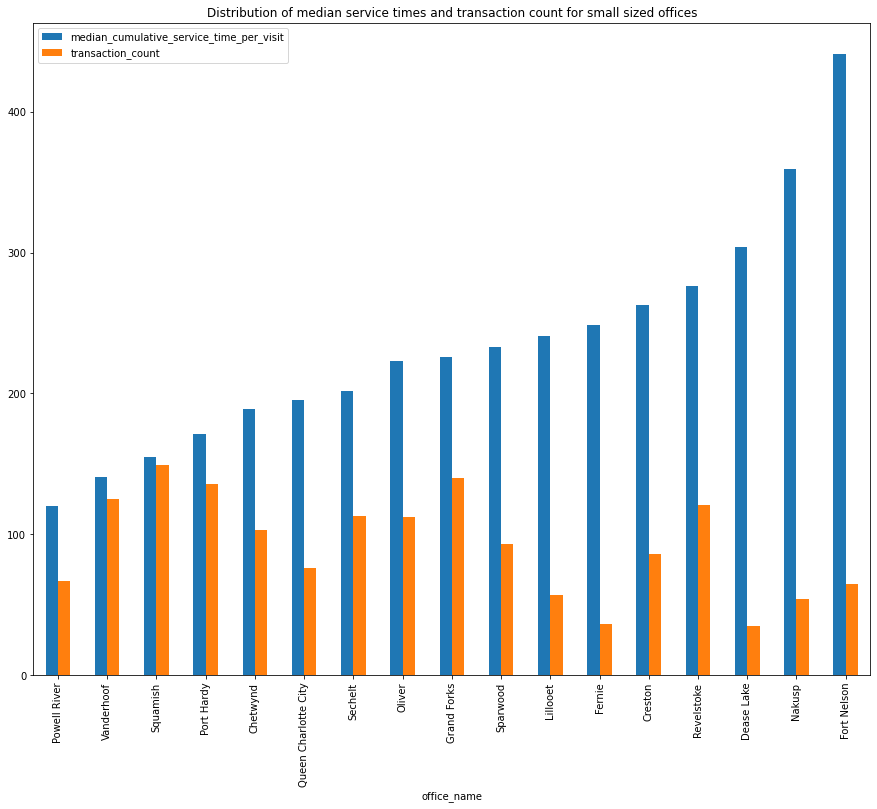

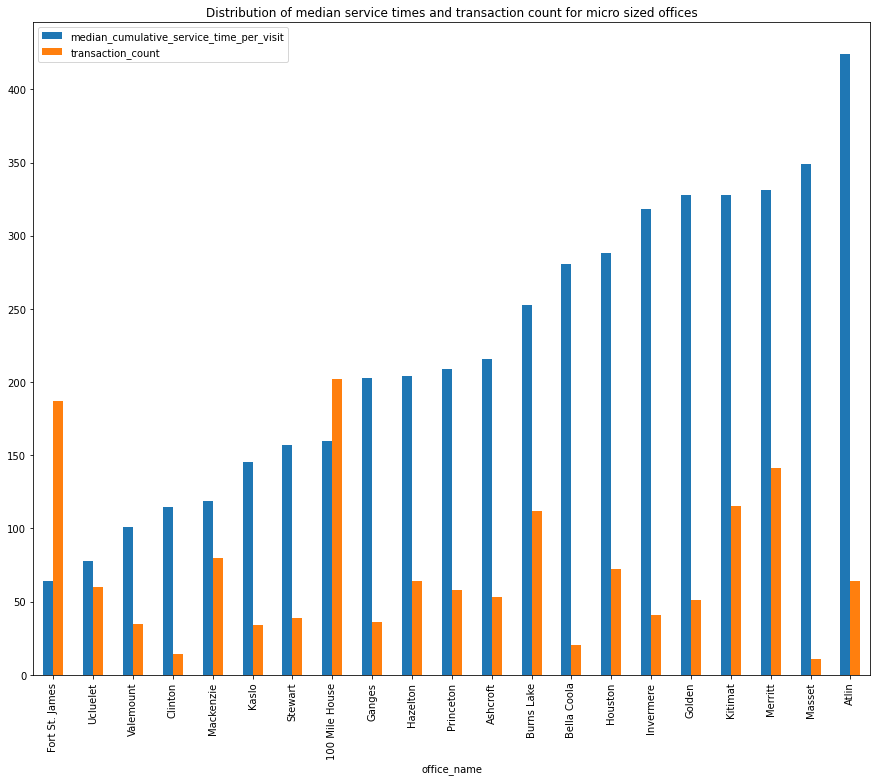

In [657]:
office_sizes = ['LARGE','MEDIUM','SMALL','MICRO']
for office_size in office_sizes:
    plot_df = time_stats_by_office[time_stats_by_office['office_size']==office_size].sort_values(by='median_cumulative_service_time_per_visit')
    title = 'Distribution of median service times and transaction count for {} sized offices'.format(office_size.lower())
    plot_df.plot(x='office_name', y=['median_cumulative_service_time_per_visit','transaction_count'],kind='bar',figsize=(15,12),title=title)
    plt.savefig('./output/distribution of median service times by office size.png')

* Let's bring in population data for each city for demographic analysis. I've used the pop_municipal_subprov_areas and recreated average population for each city in the dataset

In [658]:
population_df = pd.read_csv('./data/population.csv')
population_df.head()

,city,population
0,100 Mile House,2026
1,Ashcroft,1703
2,Atlin,424
3,Bella Coola,937
4,Burns Lake,1887


In [659]:
merged_visit_df = merged_visit_df.merge(population_df,left_on='office_name',right_on='city',how='left')
merged_visit_df.head().T

,0,1,2,3,4
back_office,Back Office,Back Office,Front Office,Back Office,Front Office
channel,back-office,back-office,in-person,back-office,in-person
client_id,4736921,5117850,1131655,4105534,4380879
counter_type,Counter,Counter,NaN,Counter,Counter
date,2020-09-28 00:00:00,2020-11-30 00:00:00,2019-01-31 00:00:00,2020-06-09 00:00:00,2020-07-28 00:00:00
inaccurate_time,No,No,Yes,No,Yes
no_wait_visit,Yes,Yes,No,Yes,No
office_id,94,111,94,94,94
office_name,Victoria,Victoria,Victoria,Victoria,Victoria
program_id,Back Office - 002,ID Verification - 010,SDPR - POC - 009,Back Office - 020,MSP - 001


* per capita transaction counts

In [660]:
per_capita_transactions = merged_visit_df.groupby(['office_name','population']).agg(transactions_count=('client_id','count')).reset_index()
per_capita_transactions

,office_name,population,transactions_count
0,100 Mile House,2026.0,202
1,Ashcroft,1703.0,53
2,Atlin,424.0,64
3,Bella Coola,937.0,20
4,Burnaby,270264.0,186
...,...,...,...
58,Vancouver,706012.0,151
59,Vanderhoof,4719.0,125
60,Vernon,45549.0,628
61,Victoria,96390.0,373


In [661]:
per_capita_transactions['transactions_per_thousand'] = 1000*per_capita_transactions['transactions_count']/per_capita_transactions['population']
per_capita_transactions.sort_values(by='transactions_per_thousand')

,office_name,population,transactions_count,transactions_per_thousand
58,Vancouver,706012.0,151,0.213877
53,Surrey,633234.0,181,0.285834
4,Burnaby,270264.0,186,0.688216
27,Kelowna,153385.0,192,1.251752
25,Kamloops,103159.0,285,2.762726
...,...,...,...,...
18,Fort St. James,1700.0,187,110.000000
2,Atlin,424.0,64,150.943396
17,Fort Nelson,419.0,65,155.131265
22,Hazelton,339.0,64,188.790560


* Time series plots

In [662]:
merged_visit_df['week_day'] = merged_visit_df['welcome_time'].dt.day_name()
merged_visit_df['week_day']

0           Monday
1           Monday
2         Thursday
3          Tuesday
4          Tuesday
           ...    
11852       Friday
11853      Tuesday
11854    Wednesday
11855    Wednesday
11856     Thursday
Name: week_day, Length: 11857, dtype: object

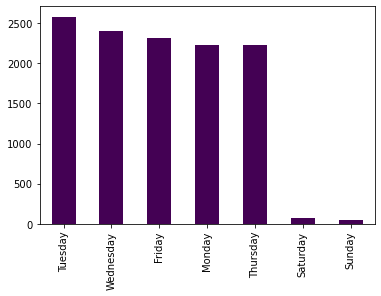

In [663]:
merged_visit_df['week_day'].value_counts().plot(kind='bar',colormap='viridis');

In [664]:
merged_visit_df[merged_visit_df['week_day'].isin(['Saturday','Sunday'])]

,back_office,channel,client_id,counter_type,date,inaccurate_time,no_wait_visit,office_id,office_name,program_id,...,office_size,area_name,latitude,longitude,total_service_time,cumulative_service_time_per_service,cumulative_service_time_per_visit,city,population,week_day
96,Front Office,in-person,7769599,Counter,2021-09-12,No,Yes,94,Victoria,ID Verification - 010,...,LARGE,Lower Mainland Capital,48.458359,-123.377106,87.0,87.0,87.0,Victoria,96390.0,Sunday
172,Front Office,in-person,7783885,Counter,2021-09-12,No,Yes,94,Victoria,ID Verification - 010,...,LARGE,Lower Mainland Capital,48.458359,-123.377106,33.0,33.0,33.0,Victoria,96390.0,Sunday
348,Front Office,in-person,7755994,Counter,2021-09-11,No,Yes,94,Victoria,ID Verification - 010,...,LARGE,Lower Mainland Capital,48.458359,-123.377106,29.0,29.0,29.0,Victoria,96390.0,Saturday
425,Back Office,back-office,7588288,Counter,2021-09-05,No,Yes,17,Cranbrook,ID Verification - 010,...,LARGE,Kootenay,49.514183,-115.766701,31.0,30.0,30.0,Cranbrook,21882.0,Sunday
644,Front Office,in-person,7768456,Counter,2021-09-12,No,Yes,17,Cranbrook,ID Verification - 010,...,LARGE,Kootenay,49.514183,-115.766701,51.0,51.0,51.0,Cranbrook,21882.0,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11259,Back Office,back-office,7577985,Counter,2021-09-04,No,Yes,90,Surrey,ID Verification - 010,...,MEDIUM,Lower Mainland Capital,49.192823,-122.800242,28.0,28.0,28.0,Surrey,633234.0,Saturday
11265,Back Office,back-office,7578471,Counter,2021-09-04,No,Yes,90,Surrey,ID Verification - 010,...,MEDIUM,Lower Mainland Capital,49.192823,-122.800242,39.0,39.0,39.0,Surrey,633234.0,Saturday
11284,Front Office,in-person,7976518,Counter,2021-09-19,No,Yes,90,Surrey,ID Verification - 010,...,MEDIUM,Lower Mainland Capital,49.192823,-122.800242,22.0,22.0,22.0,Surrey,633234.0,Sunday
11762,Back Office,back-office,4898012,Counter,2020-10-24,No,Yes,41,Kaslo,Back Office - 021,...,MICRO,Kootenay,49.911354,-116.904266,152.0,152.0,152.0,Kaslo,1045.0,Saturday


In [665]:
merged_visit_df[merged_visit_df['week_day'].isin(['Saturday','Sunday'])]['date'].unique()

array(['2021-09-12T00:00:00.000000000', '2021-09-11T00:00:00.000000000',
       '2021-09-05T00:00:00.000000000', '2021-09-04T00:00:00.000000000',
       '2021-09-18T00:00:00.000000000', '2021-08-28T00:00:00.000000000',
       '2021-09-19T00:00:00.000000000', '2020-10-24T00:00:00.000000000',
       '2020-04-11T00:00:00.000000000', '2021-08-14T00:00:00.000000000',
       '2020-10-17T00:00:00.000000000', '2020-07-11T00:00:00.000000000',
       '2021-08-29T00:00:00.000000000', '2020-07-25T00:00:00.000000000',
       '2022-02-05T00:00:00.000000000', '2021-01-02T00:00:00.000000000',
       '2020-10-11T00:00:00.000000000'], dtype='datetime64[ns]')

* Area wise performance over time

In [666]:
time_stats_by_area = merged_visit_df[time_cols +['client_id','area_name']].groupby(['area_name']).agg(transaction_count = ('client_id','count'),
                                                                                                                                    median_serve_duration_per_service = ('serve_duration_per_service','median'),
                                                                                                                        median_serve_duration_per_visit = ('serve_duration_per_visit','median'),
                                                                                                                        median_service_creation_duration_per_visit = ('service_creation_duration_per_vi','median'),
                                                                                                                        median_prep_duration_per_visit = ('prep_duration_per_visit','median'),
                                                                                                                        median_prep_duration_per_service = ('prep_duration_per_service','median'),
                                                                                                                        median_waiting_duration_per_visit = ('waiting_duration_per_visit','median'),
                                                                                                                        median_waiting_duration_per_service = ('waiting_duration_per_service','median'),
                                                                                                                        median_hold_duration_per_visit = ('hold_duration_per_visit','median'),
                                                                                                                        median_hold_duration_per_service = ('hold_duration_per_service','median'),
                                                                                                                        median_total_service_time = ('total_service_time','median'),
                                                                                                                        median_cumulative_service_time_per_service = ('cumulative_service_time_per_service','median'),
                                                                                                                        median_cumulative_service_time_per_visit = ('cumulative_service_time_per_visit','median'),
                                                                                                                        mean_serve_duration_per_service = ('serve_duration_per_service','mean'),
                                                                                                                        mean_serve_duration_per_visit = ('serve_duration_per_visit','mean'),
                                                                                                                        mean_service_creation_duration_per_visit = ('service_creation_duration_per_vi','mean'),
                                                                                                                        mean_prep_duration_per_visit = ('prep_duration_per_visit','mean'),
                                                                                                                        mean_prep_duration_per_service = ('prep_duration_per_service','mean'),
                                                                                                                        mean_waiting_duration_per_visit = ('waiting_duration_per_visit','mean'),
                                                                                                                        mean_waiting_duration_per_service = ('waiting_duration_per_service','mean'),
                                                                                                                        mean_hold_duration_per_visit = ('hold_duration_per_visit','mean'),
                                                                                                                        mean_hold_duration_per_service = ('hold_duration_per_service','mean'),
                                                                                                                        mean_total_service_time = ('total_service_time','mean'),
                                                                                                                        mean_cumulative_service_time_per_service = ('cumulative_service_time_per_service','mean'),
                                                                                                                        mean_cumulative_service_time_per_visit = ('cumulative_service_time_per_visit','mean')
                                                                                                              ).reset_index()

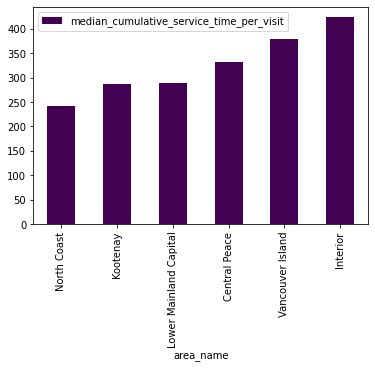

In [667]:
time_stats_by_area.sort_values(by='median_cumulative_service_time_per_visit').plot(x='area_name',y=['median_cumulative_service_time_per_visit'],kind='bar',colormap='viridis');

In [668]:
merged_visit_df['cumulative_service_time_per_visit'].quantile(0.95)

2859.399999999998

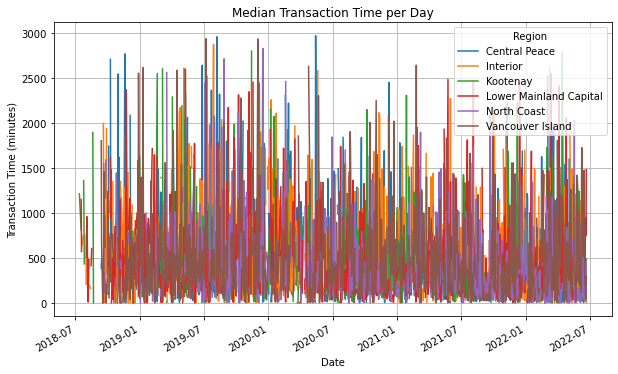

In [669]:
filtered_df = merged_visit_df[merged_visit_df['cumulative_service_time_per_visit']<3000]
median_times = filtered_df.groupby(['date', 'area_name'])['cumulative_service_time_per_visit'].median().unstack()

# Plot the median transaction time per day for each region
median_times.plot.line(figsize=(10, 6))

# Customize the plot
plt.title('Median Transaction Time per Day')
plt.xlabel('Date')
plt.ylabel('Transaction Time (minutes)')
plt.legend(title='Region')
plt.grid(True)

# Display the plot
plt.show()

<Axes: xlabel='date'>

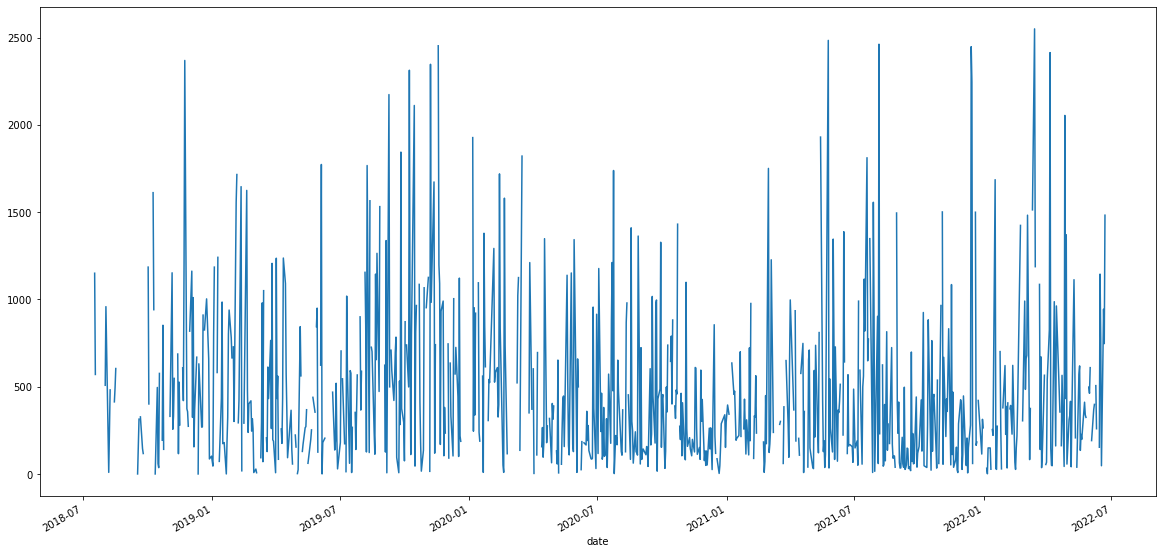

In [670]:
median_times['Lower Mainland Capital'].plot(kind='line',figsize=(20,10))

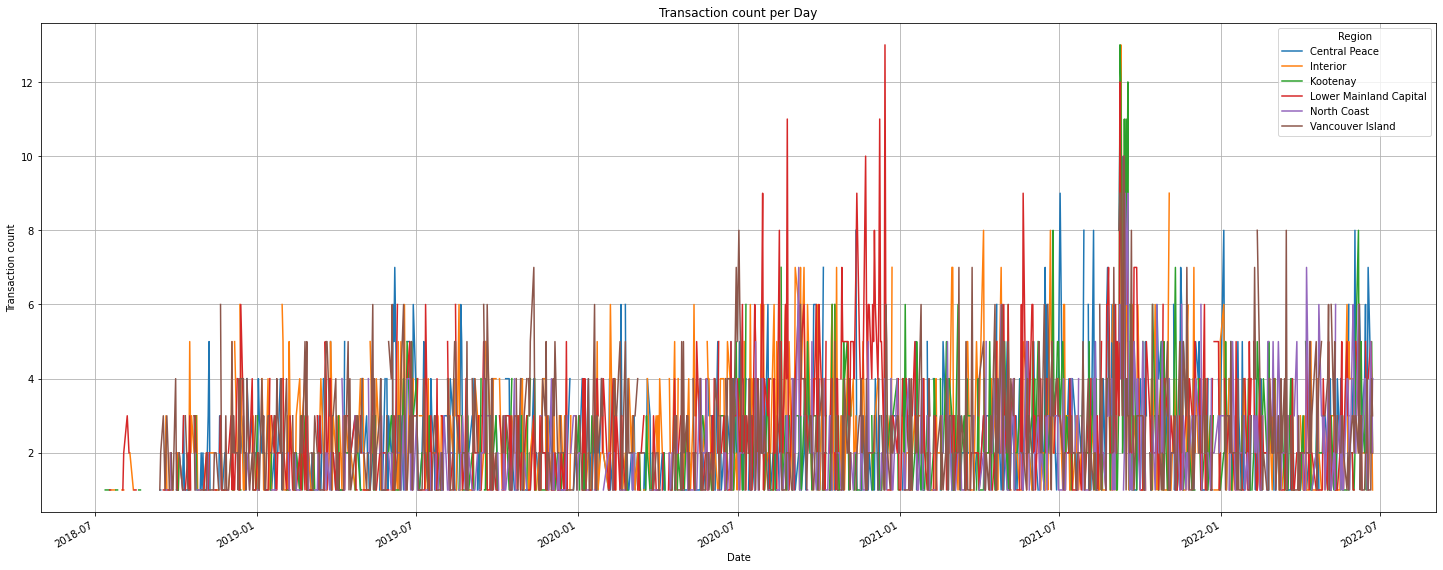

In [671]:
trans_count = filtered_df.groupby(['date', 'area_name'])['client_id'].count().unstack()

# Plot the median transaction time per day for each region
trans_count.plot.line(figsize=(25, 10))

# Customize the plot
plt.title('Transaction count per Day')
plt.xlabel('Date')
plt.ylabel('Transaction count')
plt.legend(title='Region')
plt.grid(True)

# Display the plot
plt.show()

* Weekly analysis

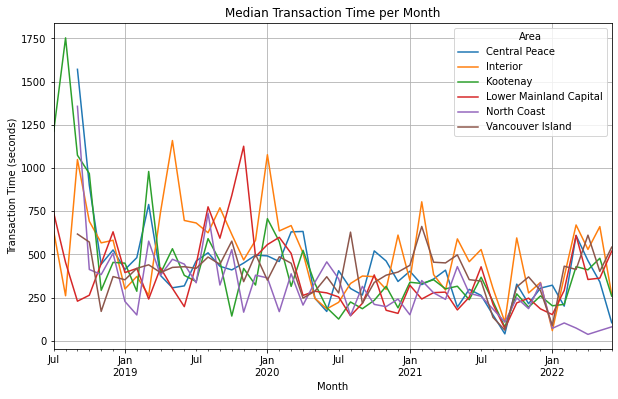

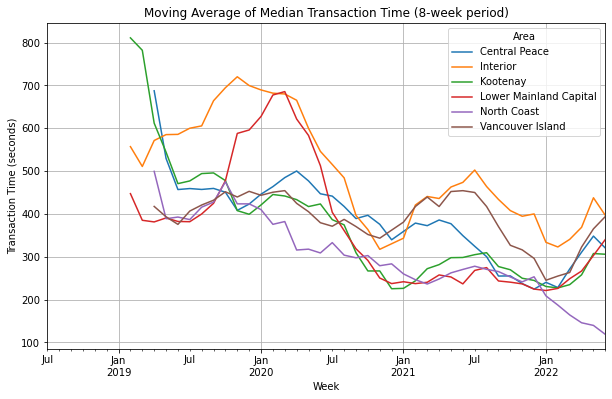

In [672]:
# Calculate the median transaction time per week for each region
median_times_per_week = merged_visit_df.groupby([pd.Grouper(key='date', freq='M'), 'area_name'])['cumulative_service_time_per_visit'].median().unstack()

# Calculate the moving average of the median transaction time over a 3-week period
moving_avg = median_times_per_week.rolling(window=8).mean()

# Plot the median transaction time per week for each region
median_times_per_week.plot(kind='line', figsize=(10, 6))

# Customize the plot
plt.title('Median Transaction Time per Month')
plt.xlabel('Month')
plt.ylabel('Transaction Time (seconds)')
plt.legend(title='Area')
plt.grid(True)

# Create a separate plot for the moving average
moving_avg.plot(kind='line', figsize=(10, 6))

# Customize the moving average plot
plt.title('Moving Average of Median Transaction Time (8-week period)')
plt.xlabel('Week')
plt.ylabel('Transaction Time (seconds)')
plt.legend(title='Area')
plt.grid(True)

# Display the plots
plt.show()

In [673]:
covid_df = pd.read_csv('./data/covid19.csv',parse_dates=True)
covid_df.head()

,Reported_Date,HA,Sex,Age_Group,Classification_Reported
0,06-02-2020,Vancouver Coastal,F,50-59,Lab-diagnosed
1,18-02-2020,Interior,F,30-39,Lab-diagnosed
2,24-02-2020,Fraser,F,30-39,Lab-diagnosed
3,24-02-2020,Fraser,M,40-49,Lab-diagnosed
4,03-03-2020,Fraser,M,50-59,Lab-diagnosed


In [674]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374886 entries, 0 to 374885
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Reported_Date            374886 non-null  object
 1   HA                       374886 non-null  object
 2   Sex                      374886 non-null  object
 3   Age_Group                374886 non-null  object
 4   Classification_Reported  374886 non-null  object
dtypes: object(5)
memory usage: 14.3+ MB


<ipython-input-675-98ec42f631cd>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  covid_df['date'] = pd.to_datetime(covid_df['Reported_Date'])


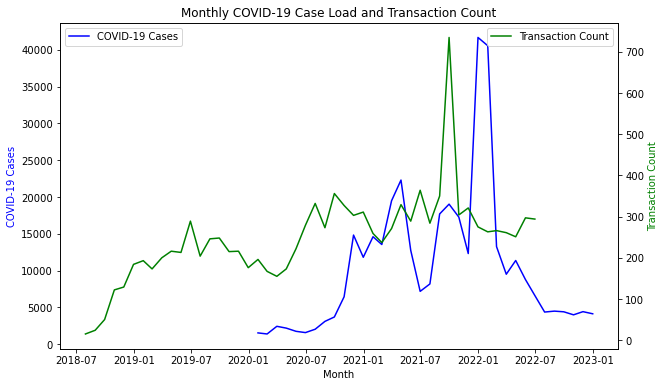

In [675]:
# Preprocess COVID-19 data
covid_df['date'] = pd.to_datetime(covid_df['Reported_Date'])
monthly_case_counts = covid_df.groupby(pd.Grouper(key='date', freq='M')).size()

# Preprocess transaction dat
monthly_transaction_counts = merged_visit_df.groupby(pd.Grouper(key='date', freq='M')).size()

# Create a single plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot monthly case counts on the first y-axis
ax1.plot(monthly_case_counts.index, monthly_case_counts.values, label='COVID-19 Cases', color='blue')
ax1.set_ylabel('COVID-19 Cases', color='blue')

# Plot monthly transaction counts on the second y-axis
ax2.plot(monthly_transaction_counts.index, monthly_transaction_counts.values, label='Transaction Count', color='green')
ax2.set_ylabel('Transaction Count', color='green')

# Customize the plot
ax1.set_title('Monthly COVID-19 Case Load and Transaction Count')
ax1.set_xlabel('Month')

# Display legends for both y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

<ipython-input-676-43a55141b296>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  covid_df['date'] = pd.to_datetime(covid_df['Reported_Date'])


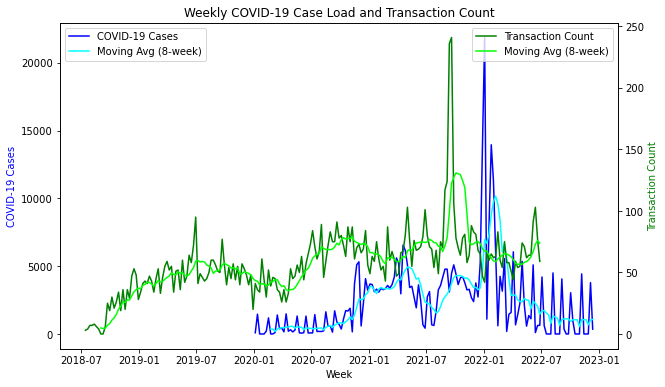

In [676]:
# Preprocess COVID-19 data
covid_df['date'] = pd.to_datetime(covid_df['Reported_Date'])
weekly_case_counts = covid_df.groupby(pd.Grouper(key='date', freq='W')).size()
moving_avg_covid = weekly_case_counts.rolling(window=8).mean()

# Preprocess transaction data
weekly_transaction_counts = merged_visit_df.groupby(pd.Grouper(key='date', freq='W')).size()
moving_avg_transaction = weekly_transaction_counts.rolling(window=8).mean()

# Create a single plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot weekly COVID-19 case counts with 8-week moving average on the first y-axis
ax1.plot(weekly_case_counts.index, weekly_case_counts.values, label='COVID-19 Cases', color='blue')
ax1.plot(moving_avg_covid.index, moving_avg_covid.values, label='Moving Avg (8-week)', color='cyan')
ax1.set_ylabel('COVID-19 Cases', color='blue')

# Plot weekly transaction counts with 8-week moving average on the second y-axis
ax2.plot(weekly_transaction_counts.index, weekly_transaction_counts.values, label='Transaction Count', color='green')
ax2.plot(moving_avg_transaction.index, moving_avg_transaction.values, label='Moving Avg (8-week)', color='lime')
ax2.set_ylabel('Transaction Count', color='green')

# Customize the plot
ax1.set_title('Weekly COVID-19 Case Load and Transaction Count')
ax1.set_xlabel('Week')

# Display legends for both y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

* First nations locations

In [677]:
# Path to the shapefile
shapefile_path = './data/location_data/Premiere_Nation_First_Nation_SHP/Premiere_Nation_First_Nation.shp'

# Read the shapefile into a GeoDataFrame
first_nations_gdf = gpd.read_file(shapefile_path)

In [678]:
first_nations_gdf

,BAND_NBR,BAND_NAME,geometry
0,168,Munsee-Delaware Nation,POINT (-81.46830 42.78799)
1,120,Mississaugas of the Credit,POINT (-80.09515 43.00002)
2,23,Eskasoni,POINT (-60.64555 45.93052)
3,468,Fort McMurray #468 First Nation,POINT (-111.15746 56.41353)
4,461,Mikisew Cree First Nation,POINT (-111.09969 58.75706)
...,...,...,...
632,151,Northwest Angle No.33,POINT (-95.01585 49.36315)
633,397,Ministikwan Lake Cree Nation,POINT (-109.66957 54.05013)
634,601,Westbank First Nation,POINT (-119.60531 49.83982)
635,83,Première Nation des Innus de Nutashkuan,POINT (-61.80242 50.13366)


In [679]:
bc_boundary

,PRUID,DGUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,LANDAREA,geometry
9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544,"MULTIPOLYGON (((3843551.097 2389750.100, 38435..."


In [680]:
# Reproject the First Nations data to match the CRS of BC boundaries
first_nations_gdf = first_nations_gdf.to_crs(bc_boundary.crs)

# Perform a spatial join to determine First Nations within BC
first_nations_bc = gpd.sjoin(first_nations_gdf, bc_boundary, how='inner', op='within')

# Reproject the First Nations data to match the CRS of office gdf
first_nations_reserves = first_nations_bc.to_crs(office_gdf.crs)

# Create a list to store the nearest office name for each First Nation reserve
nearest_office_names = []

# Iterate over First Nations reserves and find the nearest office name
for idx, reserve in first_nations_reserves.iterrows():
    nearest_office = office_gdf.distance(reserve.geometry).idxmin()
    nearest_office_name = office_gdf.loc[nearest_office]['office_name']
    nearest_office_names.append(nearest_office_name)

# Create a DataFrame with First Nations reserves and their nearest office name
nearest_office_df = pd.DataFrame({'First_Nation_Reserve': first_nations_reserves['BAND_NAME'],
                                  'Nearest_Office_Name': nearest_office_names})

# Display the DataFrame
nearest_office_df.head()

C:\Users\vindurth\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3337: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-680-c6709db3fca0>:15: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_office = office_gdf.distance(reserve.geometry).idxmin()


,First_Nation_Reserve,Nearest_Office_Name
6,Williams Lake First Nation,Williams Lake
15,Tsartlip,Victoria
21,Boothroyd,Merritt
25,Uchucklesaht,Port Alberni
27,Ditidaht,Port Alberni


In [681]:
first_nations_bc

,BAND_NBR,BAND_NAME,geometry,index_right,PRUID,DGUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,LANDAREA
6,719,Williams Lake First Nation,POINT (4232997.912 2249012.976),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
15,653,Tsartlip,POINT (3959456.891 1950696.370),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
21,700,Boothroyd,POINT (4158257.434 2020054.288),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
25,667,Uchucklesaht,POINT (3882458.395 2049659.679),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
27,662,Ditidaht,POINT (3894272.100 2015864.765),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
...,...,...,...,...,...,...,...,...,...,...,...,...
624,669,Old Massett Village Council,POINT (3772825.503 2780098.431),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
625,649,Nanoose First Nation,POINT (3953017.284 2039608.515),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
627,651,Qualicum First Nation,POINT (3929894.303 2070773.721),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
629,530,Witset First Nation,POINT (4088282.871 2696590.663),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544


In [682]:
nearest_office_df[nearest_office_df['Nearest_Office_Name']=='Vancouver']

,First_Nation_Reserve,Nearest_Office_Name
471,Squamish,Vancouver
491,Musqueam,Vancouver


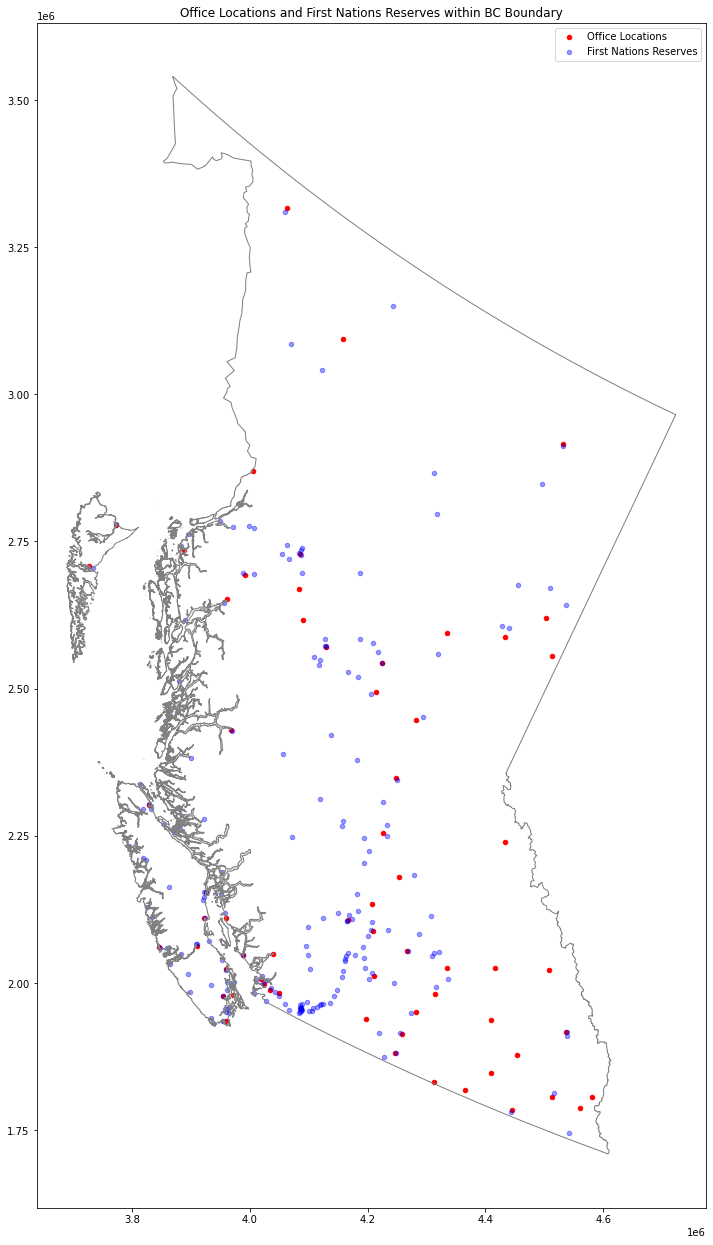

In [683]:
# Reproject all datasets to the CRS of the BC boundary
office_gdf = office_gdf.to_crs(bc_boundary.crs)
first_nations_reserves = first_nations_reserves.to_crs(bc_boundary.crs)


# Plot all the offices, First Nations reserves, and BC boundary
fig, ax = plt.subplots(figsize=(12, 25))
bc_boundary.boundary.plot(ax=ax, color='gray', linewidth=1)
office_gdf.plot(ax=ax, color='red', markersize=20, label='Office Locations')
first_nations_reserves.plot(ax=ax, color='blue', markersize=20, alpha=0.4, label='First Nations Reserves')

plt.title('Office Locations and First Nations Reserves within BC Boundary')
plt.legend()
plt.savefig('./output/first nations within BC.png')
plt.show()

In [684]:
nearest_office_df.groupby('Nearest_Office_Name')['First_Nation_Reserve'].count().sort_values(ascending=False)

Nearest_Office_Name
Chilliwack        24
Port Hardy        12
Ashcroft          10
Victoria           8
Hazelton           8
Campbell River     8
Lillooet           8
Williams Lake      7
Merritt            7
Burns Lake         7
Ucluelet           6
Port Alberni       5
Fort St. James     5
Prince Rupert      4
Terrace            4
Maple Ridge        4
Duncan             4
Salmon Arm         4
Bella Coola        4
Quesnel            4
Kitimat            3
Kamloops           3
Nanaimo            3
Ganges             3
Dease Lake         3
Chetwynd           3
Burnaby            3
Powell River       2
Surrey             2
Vancouver          2
Vanderhoof         2
Squamish           2
Mackenzie          2
Invermere          2
Fort St. John      2
Oliver             2
Fort Nelson        2
Penticton          1
Fernie             1
Atlin              1
Vernon             1
Courtenay          1
Cranbrook          1
Creston            1
Daajing Giids      1
Smithers           1
Stewart       

* Statisics Canada defines a rural area as: 
* *Areas with fewer than 1,000 inhabitants and a population density below 400 people per square kilometre*
* Based on this, from the 2021 cenusus data, I have created the following dataset.


In [685]:
urban_pop = pd.read_csv('./data/urban_population.csv')
urban_pop.head()

,city,city_type,median_age,population_density_per_square_km,pop_2021,is_urban
0,Abbotsford,City,39.2,409.0,153524,1
1,Anmore,Village,45.6,85.6,2356,0
2,Ashcroft,Village,58.4,32.8,1670,0
3,Barriere,District municipality,58.4,164.5,1765,0
4,Belcarra,Village,55.2,124.8,687,0


In [686]:
urban_df = merged_visit_df.merge(urban_pop,on='city',how='inner')

In [687]:
urban_df.shape[0]

6484

In [701]:
urban_df.groupby('is_urban')['office_name'].nunique()

is_urban
0    17
1    15
Name: office_name, dtype: int64

In [688]:
urban_df['is_urban'].value_counts()/urban_df['is_urban'].count()

1    0.585595
0    0.414405
Name: is_urban, dtype: float64

In [696]:
transaction_count_by_pop_type = urban_df.groupby(['is_urban','program_id']).agg(transaction_count=('client_id','count')).reset_index()

In [698]:
transaction_count_by_pop_type[transaction_count_by_pop_type['is_urban']==0].sort_values(by=['transaction_count'])

,is_urban,program_id,transaction_count
69,0,MCFD - 011,1
26,0,Back Office - 025,1
102,0,Other - 51,1
33,0,Exams - 009,1
37,0,Exams - 017,1
...,...,...,...
9,0,Back Office - 004,74
52,0,ICBC - 008,125
62,0,ID Verification - 010,257
23,0,Back Office - 021,304


In [699]:
transaction_count_by_pop_type[transaction_count_by_pop_type['is_urban']==1].sort_values(by=['transaction_count'])

,is_urban,program_id,transaction_count
169,1,Back Office - 027,1
194,1,ICBC - 007,1
228,1,Other - 008,1
232,1,Other - 016,1
183,1,F&W - 005,1
...,...,...,...
196,1,ICBC - 009,129
195,1,ICBC - 008,151
165,1,Back Office - 021,327
208,1,ID Verification - 010,436
